In [2]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import copy

#plots
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

#tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from tensorflow.keras.layers import BatchNormalization
from keras import metrics
from keras import utils

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16

%matplotlib inline

#Import CIFAR-10 Classification
from keras.datasets import cifar10

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [5]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)
x_test shape:  (10000, 32, 32, 3)
y_test shape:  (10000, 1)


In [6]:
# Pixel values range from 0 to 255. To normalize the data, just divide all values by 255.
x_train = x_train / 255
x_test = x_test / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
y_train = y_train.flatten()
y_test = y_test.flatten()

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(x_train.shape[0])
shuffled_indices = np.random.permutation(indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

# make a deep copy of y for the confusion matrix

y_train1 = copy.deepcopy(y_train)
y_test1 = copy.deepcopy(y_test)

In [7]:
# use pretrained VGG16 models with fixed weights and non-trainable layers: 

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Data augmentation
data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
data_generator.fit(x_train)

# Load VGG16 model with imagenet weights, without the top layer
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the VGG16 base model
for layer in vgg16_base.layers:
    layer.trainable = False

# Create the custom model with the VGG16 base
model = models.Sequential()
model.add(vgg16_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
batch_size = 64
epochs = 10
history = model.fit(
    data_generator.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

history1 = pd.DataFrame(history.history)
display(history1.iloc[-1:])
print(model.summary())

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/10
782/782 [==============================] - 41s 40ms/step - loss: 1.5471 - accuracy: 0.4550 - val_loss: 1.3037 - val_accuracy: 0.5430
Epoch 2/10
782/782 [==============================] - 30s 38ms/step - loss: 1.3759 - accuracy: 0.5160 - val_loss: 1.2394 - val_accuracy: 0.5672
Epoch 3/10
782/782 [==============================] - 30s 38ms/step - loss: 1.3229 - accuracy: 0.5346 - val_loss: 1.2152 - val_accuracy: 0.5719
Epoch 4/10
782/782 [==============================] - 30s 38ms/step - loss: 1.2999 - accuracy: 0.5435 - val_loss: 1.1886 - val_accuracy: 0.5851
Epoch 5/10
782/782 [==============================] - 30s 39ms/step - loss: 1.2832 - accuracy: 0.5481 - val_loss: 1.1705 - val_accuracy: 0.5914
Epoch 6/10
782/782 [==============================] - 29s 37ms/step - loss: 1.2653 - accuracy: 0.5552 - val_loss: 1.1764 - val_accuracy: 0.5868
Epoch 7/10
782/782 [==============================] - 30s 38ms/step - l

,loss,accuracy,val_loss,val_accuracy
9,1.210621,0.57474,1.12378,0.6043


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________
None


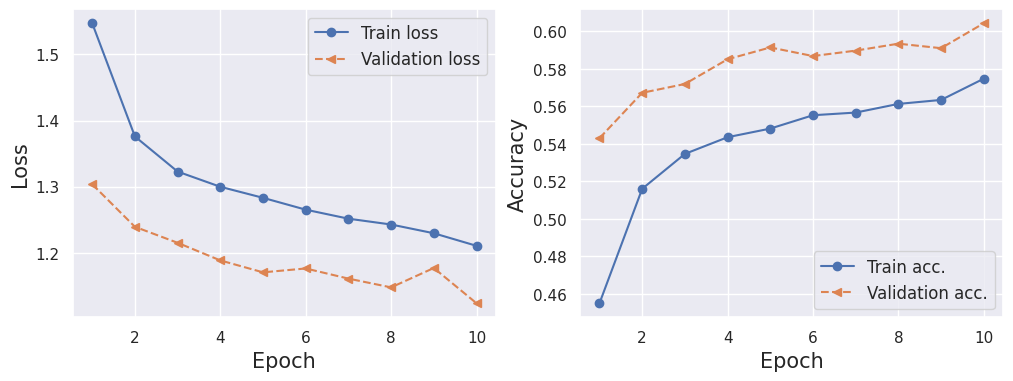

313/313 [==============================] - 3s 8ms/step - loss: 1.1238 - accuracy: 0.6043
Test accuracy: 0.6043000221252441


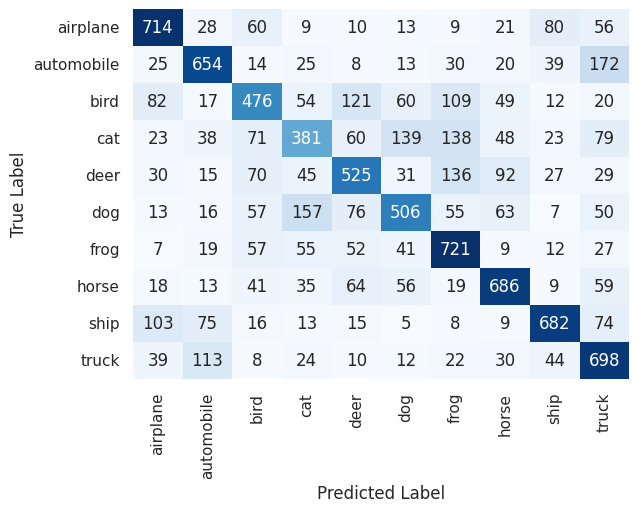

In [8]:
# create a function to examine model results

def plot_results(history, x_test, y_test, label_names):
    
    # plot loss and accuracy
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=12)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

    # model.predict gives a vector of probabilities for each x.
    # Get labels by taking the argmax -- the index with the largest probability.
    test_predictions = np.argmax(model.predict(x_test), axis=-1)
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print("Test accuracy:", test_acc)

    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(y_test1, test_predictions)

    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                    xticklabels=label_names, yticklabels=label_names, cbar=False)

    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
  
plot_results(history, x_test, y_test, label_names)

# The following code of using VGG16 on CIFAR-10 is retreived and slightly modified from https://www.kaggle.com/code/vtu5118/cifar-10-using-vgg16

In [11]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score


In [12]:
#------------------------------------------------------------------------------
# Using VGG16 model, with weights pre-trained on ImageNet.
#------------------------------------------------------------------------------

vgg16_model = VGG16(weights='imagenet',
                    include_top=False, 
                    classes=10,
                    input_shape=(32,32,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

In [13]:
#Define the sequential model and add th VGG's layers to it
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [14]:
#------------------------------------------------------------------------------
# Adding hiddens  and output layer to our model
#------------------------------------------------------------------------------

from tensorflow.keras.layers import Dense, Flatten, Dropout
model.add(Flatten())
model.add(Dense(512, activation='relu', name='hidden1'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', name='hidden2'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax', name='predictions'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [15]:
#------------------------------------------------------------------------------
#  Loading CIFAR10 data
#------------------------------------------------------------------------------

(x_train, y_train), (x_test, y_test) = k.datasets.cifar10.load_data()

print("******************")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

******************
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [16]:
# make a deep copy of y

y_train1 = copy.deepcopy(y_train)
y_test1 = copy.deepcopy(y_test)

In [17]:
# Convert class vectors to binary class matrices using one hot encoding
y_train_ohe = to_categorical(y_train, num_classes = 10)
y_test_ohe = to_categorical(y_test, num_classes = 10)

In [19]:
# Data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

print("******************")
print(x_train.shape)
print(y_train_ohe.shape)
print(x_test.shape)
print(y_test_ohe.shape)

******************
(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [20]:
x_val = x_train[40000:]
y_val = y_train_ohe[40000:]
print(x_val.shape)
print(y_val.shape)

(10000, 32, 32, 3)
(10000, 10)


In [22]:
x_train = x_train[:40000]
y_train_ohe = y_train_ohe[:40000]
print(x_train.shape)
print(y_train_ohe.shape)

(40000, 32, 32, 3)
(40000, 10)


In [24]:
#------------------------------------------------------------------------------
# TRAINING THE CNN ON THE TRAIN/VALIDATION DATA
#------------------------------------------------------------------------------

# initiate SGD optimizer
sgd = optimizers.SGD(learning_rate=0.001, momentum=0.9)

# For a multi-class classification problem
model.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])


def lr_scheduler(epoch):
    return 0.001 * (0.5 ** (epoch // 20))
reduce_lr = LearningRateScheduler(lr_scheduler)

mc = ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')


# initialize the number of epochs and batch size
EPOCHS = 10
BS = 128

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20, 
    zoom_range=0.15, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15,
    horizontal_flip=True, 
    fill_mode="nearest")
 
# train the model
history = model.fit(
    aug.flow(x_train,y_train_ohe, batch_size=BS),
    validation_data=(x_val,y_val),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    callbacks=[reduce_lr,mc])

#We load the best weights saved by the ModelCheckpoint
model.load_weights('./weights.h5')

Epoch 1/10
312/312 [==============================] - 28s 84ms/step - loss: 1.5232 - accuracy: 0.4581 - val_loss: 0.9959 - val_accuracy: 0.6469 - lr: 0.0010
Epoch 2/10
312/312 [==============================] - 25s 81ms/step - loss: 1.1214 - accuracy: 0.6148 - val_loss: 0.7983 - val_accuracy: 0.7205 - lr: 0.0010
Epoch 3/10
312/312 [==============================] - 27s 85ms/step - loss: 0.9737 - accuracy: 0.6759 - val_loss: 0.7551 - val_accuracy: 0.7428 - lr: 0.0010
Epoch 4/10
312/312 [==============================] - 25s 79ms/step - loss: 0.8841 - accuracy: 0.7010 - val_loss: 0.7187 - val_accuracy: 0.7613 - lr: 0.0010
Epoch 5/10
312/312 [==============================] - 24s 78ms/step - loss: 0.8122 - accuracy: 0.7273 - val_loss: 0.7030 - val_accuracy: 0.7606 - lr: 0.0010
Epoch 6/10
312/312 [==============================] - 25s 78ms/step - loss: 0.7593 - accuracy: 0.7445 - val_loss: 0.6125 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 7/10
312/312 [==============================] - 25s 

In [27]:
train_loss, train_accuracy = model.evaluate(x_train,y_train_ohe)
print('Training loss: {}\nTraining accuracy: {}'.format(train_loss, train_accuracy))

val_loss, val_accuracy = model.evaluate(x_val, y_val)
print('Validation loss: {}\nValidation accuracy: {}'.format(val_loss, val_accuracy))

test_loss, test_accuracy = model.evaluate(x_test,y_test_ohe,)
print('Testing loss: {}\nTesting accuracy: {}'.format(test_loss, test_accuracy))

1250/1250 [==============================] - 10s 8ms/step - loss: 0.4556 - accuracy: 0.8447
Training loss: 0.4555772840976715
Training accuracy: 0.8447499871253967
313/313 [==============================] - 2s 8ms/step - loss: 0.5126 - accuracy: 0.8244
Validation loss: 0.5125798583030701
Validation accuracy: 0.824400007724762
313/313 [==============================] - 2s 8ms/step - loss: 0.5325 - accuracy: 0.8216
Testing loss: 0.5324936509132385
Testing accuracy: 0.8216000199317932


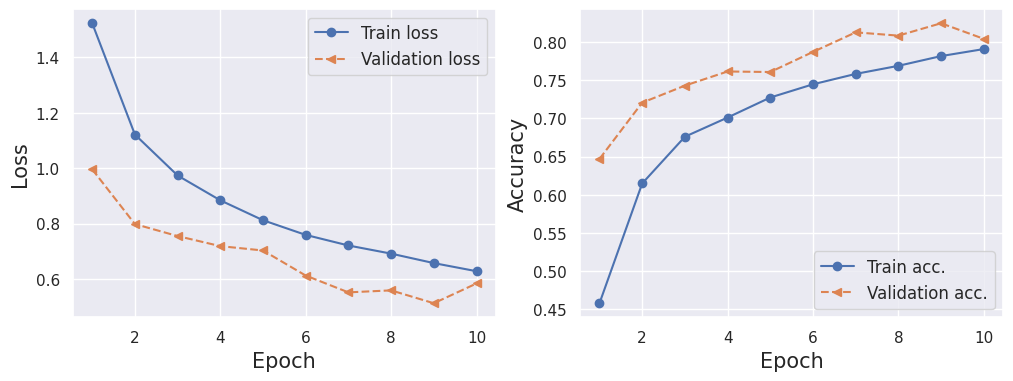

313/313 [==============================] - 2s 8ms/step - loss: 0.5325 - accuracy: 0.8216
Test accuracy: 0.8216000199317932


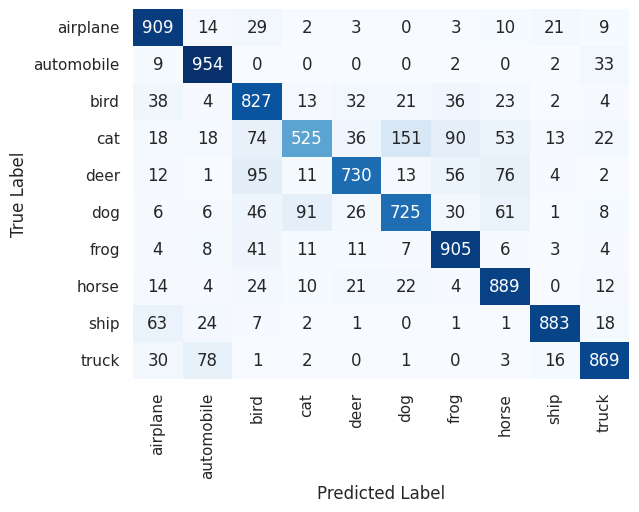

In [30]:
# create a function to examine model results

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plot_results(history, x_test, y_test_ohe, label_names)